In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepfake-detection-challenge/sample_submission.csv
/kaggle/input/deepfake-detection-challenge/test_videos/qooxnxqqjb.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hierggamuo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ocgdbrgmtq.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/icbsahlivv.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/prhmixykhr.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ihglzxzroo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/yarpxfqejd.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/orixbcfvdz.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/qxyrtwozyw.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hqzwudvhih.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ghnpsltzyn.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/ziipxxchai.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/fddmkqjwsh.mp4
/kaggle/input/deepfake-de

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
plt.style.use('ggplot')
from IPython.display import Video
from IPython.display import HTML

In [3]:
!ls -GFlash ../input/deepfake-detection-challenge


total 12K
   0 drwxr-xr-x 4 nobody    0 Dec 24 16:51 ./
4.0K drwxr-xr-x 3 root   4.0K May 20 13:24 ../
8.0K -rw-r--r-- 1 nobody 6.7K Dec 24 16:51 sample_submission.csv
   0 drwxr-xr-x 2 nobody    0 Dec 24 16:51 test_videos/
   0 drwxr-xr-x 2 nobody    0 Dec 24 16:51 train_sample_videos/


In [4]:
!du -sh ../input/deepfake-detection-challenge/


4.2G	../input/deepfake-detection-challenge/


In [5]:
train_sample_metadata = pd.read_json('../input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


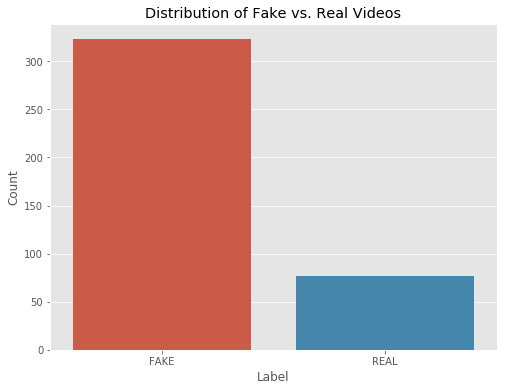

Sample frames from Fake videos:
Video: aagfhgtpmv.mp4


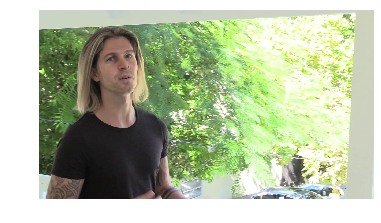

Video: aapnvogymq.mp4


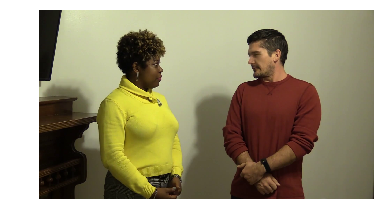

Video: abofeumbvv.mp4


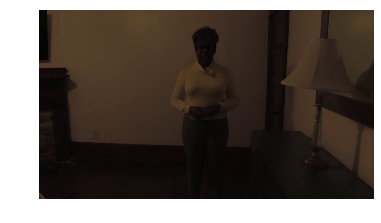

Sample frames from Real videos:
Video: abarnvbtwb.mp4


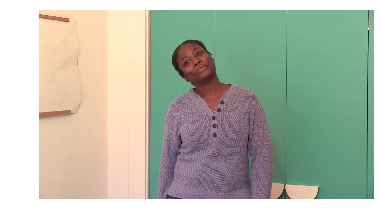

Video: aelfnikyqj.mp4


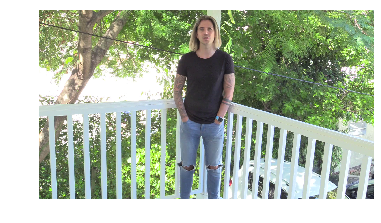

Video: afoovlsmtx.mp4


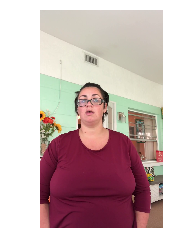

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Load metadata
train_sample_metadata = pd.read_json('../input/deepfake-detection-challenge/train_sample_videos/metadata.json').T

# Display the first few rows of the metadata
print(train_sample_metadata.head())

# Visualize the distribution of fake vs. real videos
plt.figure(figsize=(8, 6))
sns.countplot(data=train_sample_metadata, x='label')
plt.title('Distribution of Fake vs. Real Videos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Define a function to display a frame from a video
def display_video_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    else:
        print(f"Failed to read video: {video_path}")

# Path to the video folder
video_folder = '../input/deepfake-detection-challenge/train_sample_videos/'

# Display some sample frames from fake videos
fake_videos = train_sample_metadata[train_sample_metadata['label'] == 'FAKE'].index
print("Sample frames from Fake videos:")
for video in fake_videos[:3]:  # Display the first 3 fake videos
    print(f"Video: {video}")
    display_video_frame(os.path.join(video_folder, video))

# Display some sample frames from real videos
real_videos = train_sample_metadata[train_sample_metadata['label'] == 'REAL'].index
print("Sample frames from Real videos:")
for video in real_videos[:3]:  # Display the first 3 real videos
    print(f"Video: {video}")
    display_video_frame(os.path.join(video_folder, video))


In [7]:
!pip install mtcnn tensorflow opencv-python pandas numpy scikit-learn


     |████████████████████████████████| 2.3MB 1.1MB/s 


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from mtcnn import MTCNN
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

# Initialize MTCNN face detector
detector = MTCNN()

# Paths and setup
video_folder = '../input/deepfake-detection-challenge/train_sample_videos/'
metadata_path = '../input/deepfake-detection-challenge/train_sample_videos/metadata.json'

# Load metadata
train_sample_metadata = pd.read_json(metadata_path).T

# Split metadata into training and validation sets
train_metadata, val_metadata = train_test_split(train_sample_metadata, test_size=0.2, random_state=42)

class VideoFrameGenerator(Sequence):
    def __init__(self, metadata, batch_size=32, target_size=(224, 224), shuffle=True):
        self.metadata = metadata
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.metadata))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_metadata = self.metadata.iloc[batch_indexes]
        
        X, y_labels = self.__data_generation(batch_metadata)
        return X, y_labels
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_metadata):
        X = []
        y_labels = []
        
        for video_name, row in batch_metadata.iterrows():
            video_path = os.path.join(video_folder, video_name)
            label = 1 if row['label'] == 'FAKE' else 0
            
            cap = cv2.VideoCapture(video_path)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(frame_rgb)
                
                for face in faces:
                    x, y, width, height = face['box']
                    face_img = frame_rgb[y:y+height, x:x+width]
                    face_img = cv2.resize(face_img, self.target_size)  # Resize face to target_size
                    face_array = img_to_array(face_img) / 255.0  # Normalize pixel values
                    
                    X.append(face_array)
                    y_labels.append(label)
                    
                    if len(X) >= self.batch_size:
                        cap.release()
                        return np.array(X), np.array(y_labels)
            
            cap.release()
        
        # If we exit the loop and don't have enough samples, pad with the first few samples
        while len(X) < self.batch_size:
            X.append(X[0])
            y_labels.append(y_labels[0])
        
        return np.array(X), np.array(y_labels)

# Instantiate the generators
batch_size = 32
train_generator = VideoFrameGenerator(train_metadata, batch_size=batch_size)
val_generator = VideoFrameGenerator(val_metadata, batch_size=batch_size)

# Build the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

# Evaluate the model 
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Train for 10 steps, validate for 3 steps
Epoch 1/2
10/10 [==============================] - 413s 41s/step - loss: 3.8326 - accuracy: 0.6562 - val_loss: 0.6590 - val_accuracy: 0.6979
Epoch 2/2
3/3 [==============================] - 218s 73s/step - loss: 0.6434 - accuracy: 0.6979
Validation Loss: 0.6433775623639425
Validation Accuracy: 0.6979166865348816


In [9]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Initialize MTCNN face detector
detector = MTCNN()

# Load the trained model
# model = load_model('path/to/your/trained_model.h5')  # Update with the actual path to your model

# Function to detect and preprocess faces from a video
def extract_faces_from_video(video_path, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    faces = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detected_faces = detector.detect_faces(frame_rgb)

        for face in detected_faces:
            x, y, width, height = face['box']
            face_img = frame_rgb[y:y+height, x:x+width]
            face_img = cv2.resize(face_img, target_size)
            face_array = img_to_array(face_img) / 255.0
            faces.append(face_array)
    
    cap.release()
    return np.array(faces)

# Function to predict if the video is fake or real
def predict_video(video_path):
    faces = extract_faces_from_video(video_path)
    if len(faces) == 0:
        print("No faces detected in the video.")
        return None

    predictions = model.predict(faces)
    avg_prediction = np.mean(predictions)

    if avg_prediction > 0.5:
        print(f"The video '{video_path}' is predicted to be FAKE.")
    else:
        print(f"The video '{video_path}' is predicted to be REAL.")

    return avg_prediction

# Test the prediction function with a sample video
video_path = '/kaggle/input/deepfake-detection-challenge/test_videos/aassnaulhq.mp4'  # Update with the actual path to the test video
predict_video(video_path)


The video '/kaggle/input/deepfake-detection-challenge/test_videos/aassnaulhq.mp4' is predicted to be FAKE.


0.6157293